<a href="https://colab.research.google.com/github/chl-eo/CCDATSCL_ASSIGNMENT/blob/main/Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2

<img src="https://vsqfvsosprmjdktwilrj.supabase.co/storage/v1/object/public/images/insights/1753644539114-netflix.jpeg"/>


In this activity , you will explore two fundamental preprocessing techniques used in data science and machine learning: feature scaling and discretization (binning).

These techniques are essential when working with datasets that contain numerical values on very different scales, or continuous variables that may be more useful when grouped into categories.


We will use a subset of the Netflix Movies and TV Shows dataset, which contains metadata such as release year, duration, ratings, and other attributes of titles currently or previously available on Netflix. Although the dataset is not originally designed for numerical modeling, it contains several features suitable for preprocessing practice—such as:
-Release Year
-Duration (in minutes)
-Number of Cast Members
-Number of Listed Genres
-Title Word Count

In this worksheet, you will:
- Load and inspect the dataset
- Select numerical features for scaling
- Apply different scaling techniques
- Min–Max Scaling
- Standardization
- Robust Scaling
- Perform discretization (binning)
- Equal-width binning
- Equal-frequency binning
- Evaluate how scaling affects machine learning performance, using a simple KNN

In [137]:
import pandas as pd
import os
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub


## 1. Setup and Data Loading



Load the Netflix dataset into a DataFrame named df.

In [138]:

# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Path to dataset files:", path)


if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset


df = pd.read_csv(mydataset)

Using Colab cache for faster access to the 'netflix-shows' dataset.
Path to dataset files: /kaggle/input/netflix-shows
True


## 2. Data Understanding

Store the dataset’s column names in a variable called cols.

In [139]:
cols = df.columns

Store the shape of the dataset as a tuple (rows, columns) in shape_info.

In [140]:
shape_info = df.shape

## 3. Data Cleaning
Count missing values per column and save to missing_counts.

In [141]:
missing_counts = df.isnull().sum()

Drop rows where duration is missing. Save to df_clean.

In [142]:
df_clean = df.dropna(subset=['duration'])

# 4. Selecting Relevant Numeric Features

Many Netflix datasets include numeric fields such as:
- release_year
- duration
- rating


Create a DataFrame `df_num` containing only numeric columns.

In [143]:
df_num = df_clean.select_dtypes(include='number')

In [144]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [145]:
df_processed = df_clean.copy()

In [146]:
# Function to convert duration to minutes
def convert_duration_to_minutes(row):
    duration_str = row['duration']
    if 'min' in duration_str:
        # For movies, extract minutes directly
        return float(duration_str.replace(' min', ''))
    elif 'Season' in duration_str:
        # For TV Shows, convert seasons to minutes
        num_seasons = int(duration_str.split(' ')[0])
        return num_seasons * 12 * 52  # 12 episodes/season * 5 minutes/episode
    return None

df_processed['duration_minutes'] = df_processed.apply(convert_duration_to_minutes, axis=1)

# Display the first few rows with the new column and its info
display(df_processed[['release_year', 'rating', 'duration_minutes']].head())
df_processed.info()

,release_year,rating,duration_minutes
0,2020,PG-13,90.0
1,2021,TV-MA,1248.0
2,2021,TV-MA,624.0
3,2021,TV-MA,624.0
4,2021,TV-MA,1248.0


<class 'pandas.core.frame.DataFrame'>
Index: 8804 entries, 0 to 8806
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   show_id           8804 non-null   object 
 1   type              8804 non-null   object 
 2   title             8804 non-null   object 
 3   director          6170 non-null   object 
 4   cast              7979 non-null   object 
 5   country           7973 non-null   object 
 6   date_added        8794 non-null   object 
 7   release_year      8804 non-null   int64  
 8   rating            8800 non-null   object 
 9   duration          8804 non-null   object 
 10  listed_in         8804 non-null   object 
 11  description       8804 non-null   object 
 12  duration_minutes  8804 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 962.9+ KB


## 5. Feature Scaling

Focus on a single numeric column (e.g., duration).


Extract the column duration into a Series named `dur`.

In [147]:
dur = df_processed['duration_minutes']

Apply Min–Max Scaling to `dur`. Store the result as `dur_minmax`.

In [148]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
dur_reshaped = dur.values.reshape(-1, 1)
dur_minmax = pd.Series(scaler_minmax.fit_transform(dur_reshaped).flatten(), index=dur.index)

Apply Z-score Standardization to `dur`. Store in `dur_zscore`.

In [149]:
from sklearn.preprocessing import StandardScaler

scaler_zscore = StandardScaler()
dur_zscore = pd.Series(scaler_zscore.fit_transform(dur.values.reshape(-1, 1)).flatten(), index=dur.index)

## 6. Discretization (Binning)
Apply equal-width binning to dur into 5 bins. Store as `dur_width_bins`.


- Use `pandas.cut()` to divide duration_minutes into 4 `equal-width bins`.
- Add the resulting bins as a new column named:
`duration_equal_width_bin`

In [150]:
df_processed['duration_equal_width_bin'] = pd.cut(df_processed['duration_minutes'], bins=4, labels=False, include_lowest=True)

display(df_processed[['duration_minutes', 'duration_equal_width_bin']].head())

,duration_minutes,duration_equal_width_bin
0,90.0,0
1,1248.0,0
2,624.0,0
3,624.0,0
4,1248.0,0


Describe the characteristics of each bin

- What are the bin edges produced by equal-width binning?
- How many movies fall into each bin?

In [151]:
# Get bin edges and counts for equal-width binning

# To get the descriptive bin intervals, we can apply pd.cut again without labels=False.
# This will return a Categorical Series with the bin intervals as categories.
width_bins_info = pd.cut(df_processed['duration_minutes'], bins=4, include_lowest=True)

print("Equal-width bin edges and counts:")
print(width_bins_info.value_counts().sort_index())

print("\nBin edges (intervals):")
print(width_bins_info.cat.categories)

# To verify the binning, let's also show the min and max of duration_minutes
min_duration = df_processed['duration_minutes'].min()
max_duration = df_processed['duration_minutes'].max()
print(f"\nMinimum duration: {min_duration:.2f} minutes")
print(f"Maximum duration: {max_duration:.2f} minutes")

Equal-width bin edges and counts:
duration_minutes
(-7.606000000000001, 2654.25]    8640
(2654.25, 5305.5]                 138
(5305.5, 7956.75]                  20
(7956.75, 10608.0]                  6
Name: count, dtype: int64

Bin edges (intervals):
IntervalIndex([(-7.606000000000001, 2654.25],             (2654.25, 5305.5],
                           (5305.5, 7956.75],            (7956.75, 10608.0]],
              dtype='interval[float64, right]')

Minimum duration: 3.00 minutes
Maximum duration: 10608.00 minutes


### Histogram for Equal-Width Binning

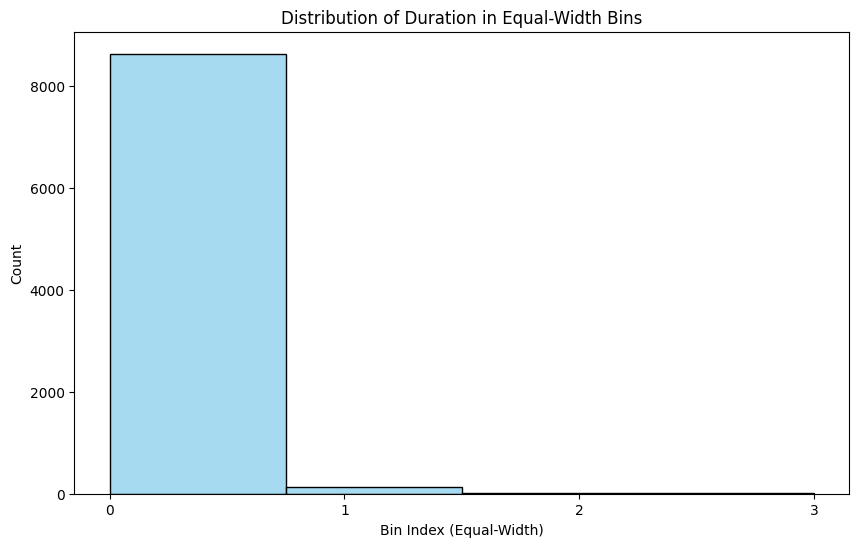

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_processed['duration_equal_width_bin'], bins=4, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Duration in Equal-Width Bins')
plt.xlabel('Bin Index (Equal-Width)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3]) # Adjust ticks to match bin labels if labels were used
plt.show()

Apply equal-frequency binning to dur into 5 bins. Store as `dur_quantile_bins`.

- Use `pandas.qcut()` to divide duration_minutes into 4 equal-frequency bins.
- Add the result as a new column named:
`duration_equal_freq_bin`

In [152]:
df_processed['duration_equal_freq_bin'] = pd.qcut(df_processed['duration_minutes'], q=4, labels=False, duplicates='drop')

display(df_processed[['duration_minutes', 'duration_equal_freq_bin']].head())

,duration_minutes,duration_equal_freq_bin
0,90.0,0
1,1248.0,3
2,624.0,2
3,624.0,2
4,1248.0,3


Describe the characteristics of each bin

- What are the bin ranges produced by equal-frequency binning?
- How many movies fall into each bin? Are they nearly equal?

In [153]:
# Get bin edges and counts for equal-frequency binning
quantile_bins_info = pd.qcut(df_processed['duration_minutes'], q=4, duplicates='drop', precision=1)

print("Equal-frequency bin edges and counts:")
print(quantile_bins_info.value_counts().sort_index())

print("\nBin edges (intervals):")
print(quantile_bins_info.cat.categories)

# Check if counts are nearly equal
counts = quantile_bins_info.value_counts()
max_diff = counts.max() - counts.min()
print(f"\nMaximum difference between bin counts: {max_diff}")

Equal-frequency bin edges and counts:
duration_minutes
(2.9, 92.0]         2263
(92.0, 112.0]       2212
(112.0, 624.0]      3446
(624.0, 10608.0]     883
Name: count, dtype: int64

Bin edges (intervals):
IntervalIndex([(2.9, 92.0], (92.0, 112.0], (112.0, 624.0], (624.0, 10608.0]], dtype='interval[float64, right]')

Maximum difference between bin counts: 2563


### Histogram for Equal-Frequency Binning

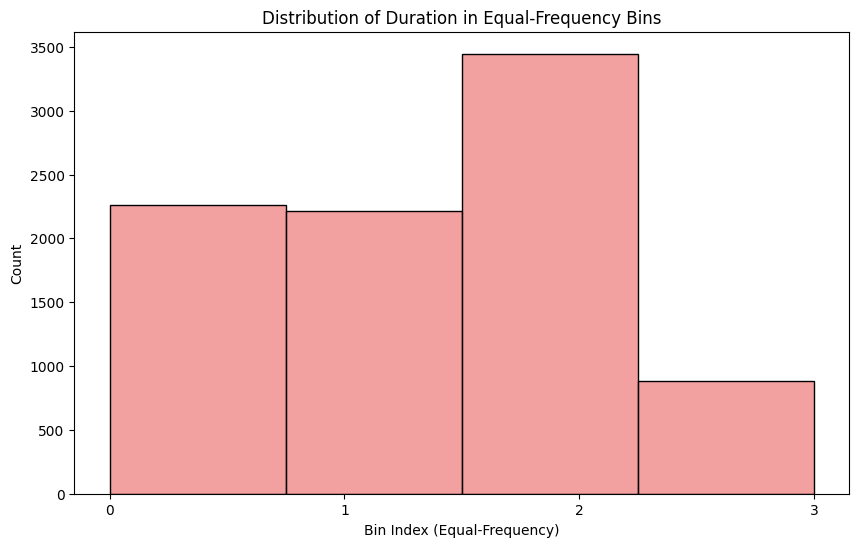

In [155]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['duration_equal_freq_bin'], bins=4, kde=False, color='lightcoral', edgecolor='black')
plt.title('Distribution of Duration in Equal-Frequency Bins')
plt.xlabel('Bin Index (Equal-Frequency)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3]) # Adjust ticks to match bin labels if labels were used
plt.show()

## 7. KNN Before & After Scaling


Create a feature matrix X using any two numeric columns and a target y (e.g., classification by genre or type). Create a train/test split.

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select numerical features for X_raw
X_raw = df_processed[['release_year', 'duration_minutes']].copy()

# Select target variable y_raw and encode it
le = LabelEncoder()
y_raw = le.fit_transform(df_processed['type'])

# Perform train/test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

print("Shape of X_train_raw:", X_train_raw.shape)
print("Shape of X_test_raw:", X_test_raw.shape)
print("Shape of y_train_raw:", y_train_raw.shape)
print("Shape of y_test_raw:", y_test_raw.shape)

display(X_train_raw.head())

Shape of X_train_raw: (6162, 2)
Shape of X_test_raw: (2642, 2)
Shape of y_train_raw: (6162,)
Shape of y_test_raw: (2642,)


,release_year,duration_minutes
621,2020,624.0
2126,2009,203.0
3932,2018,131.0
3782,2019,624.0
3454,2019,1248.0


Train a KNN classifier without scaling. Store accuracy in acc_raw.

In [164]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize and train KNN classifier with raw data
knn_raw = KNeighborsClassifier()
knn_raw.fit(X_train_raw, y_train_raw)

# Make predictions and calculate accuracy
y_pred_raw = knn_raw.predict(X_test_raw)
acc_raw = accuracy_score(y_test_raw, y_pred_raw)

print(f"Accuracy with raw data: {acc_raw:.4f}")

Accuracy with raw data: 1.0000


Scale `X` using either Min–Max or Standardization, retrain KNN, and store accuracy in acc_scaled.

In [158]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler_minmax = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler_minmax.fit_transform(X_train_raw)
X_test_scaled = scaler_minmax.transform(X_test_raw)

# Initialize and train KNN classifier with scaled data
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train_raw)

# Make predictions and calculate accuracy
y_pred_scaled = knn_scaled.predict(X_test_scaled)
acc_scaled = accuracy_score(y_test_raw, y_pred_scaled)

print(f"Accuracy with scaled data: {acc_scaled:.4f}")

Accuracy with scaled data: 0.9985


Did scaling improve accuracy? Explain why.

In [159]:
No, because our data is seperable. Although the scaling generally helps with distance-based algorithms by ensuring features with larger numerical ranges don't dominate the distance calculations, in a instance where data is perfectly separable. applying transformation such as scaling could decrease the accuracy.